Setup and Loading the Data

In [2]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import fsolve

# --- CONFIGURATION ---
INPUT_CLIMATE_FILE = "../data/interim/clean_district_climate_history.csv"
INPUT_META_FILE = "../data/processed/district_metadata.csv"
OUTPUT_DIR_FINAL = "../data/processed/"

print(f" Loading clean climate data from: {INPUT_CLIMATE_FILE}...")
df = pd.read_csv(INPUT_CLIMATE_FILE)
df['time'] = pd.to_datetime(df['time'])

print(f"Loaded {len(df):,} rows.")

 Loading clean climate data from: ../data/interim/clean_district_climate_history.csv...
Loaded 5,616,000 rows.


Calculating Relative Humidity

In [3]:
# We need Vapor Pressure (e) and Saturated Vapor Pressure (es)
# Using the August-Roche-Magnus approximation constants:
T_C = df['temp_c']
TD_C = df['dew_point_c']
a = 17.625
b = 243.04

# Saturated Vapor Pressure (es)
es = 6.112 * np.exp((a * T_C) / (b + T_C))

# Vapor Pressure (e)
e = 6.112 * np.exp((a * TD_C) / (b + TD_C))

# Relative Humidity (RH)
df['humidity_relative'] = 100 * (e / es)
df['humidity_relative'] = df['humidity_relative'].clip(0, 100) # Clip to realistic range

print("Calculated Relative Humidity.")

Calculated Relative Humidity.


Calculating Heat Index

In [4]:
def calculate_heat_index(T_C, RH):
    """NOAA/NWS Heat Index formula (Vectorized implementation)."""
    
    # 1. Convert Celsius to Fahrenheit (Fahrenheit is required for the standard formula)
    T_F = (T_C * 9/5) + 32
    
    # 2. Simple Linear Approximation (Default)
    hi = 0.5 * (T_F + 61.0 + ((T_F-68.0)*1.2) + (RH*0.094))
    
    # 3. Full Regression Formula (Apply where heat is intense, HI > 80F)
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -6.83783e-3
    c6 = -5.481717e-2
    c7 = 1.22874e-3
    c8 = 8.5282e-4
    c9 = -1.99e-6

    hi_full = (c1 + c2*T_F + c3*RH + c4*T_F*RH + c5*T_F**2 + 
               c6*RH**2 + c7*T_F**2*RH + c8*T_F*RH**2 + c9*T_F**2*RH**2)
    
    # Use full formula where simple formula predicts HI > 80F (26.7C)
    hi_final_f = np.where(hi > 80, hi_full, hi)
    
    # 4. Convert back to Celsius
    return (hi_final_f - 32) * 5/9

df['heat_index_c'] = calculate_heat_index(T_C, df['humidity_relative'])

print("Calculated Heat Index (HI).")
print(f"Max HI recorded: {df['heat_index_c'].max():.2f}°C")

Calculated Heat Index (HI).
Max HI recorded: 55.09°C


Target Variable - Risk Score Classification

In [5]:
print("--- Defining Target Variable: Risk Score ---")

# Thresholds based on NOAA NWS Heat Index Categories (converted to Celsius)
# 0: Safe (HI < 27C)
# 1: Caution (27 - 32C)
# 2: Danger (32 - 41C)
# 3: Extreme Danger (> 41C)
conditions = [
    (df['heat_index_c'] < 27),
    (df['heat_index_c'] >= 27) & (df['heat_index_c'] < 32),
    (df['heat_index_c'] >= 32) & (df['heat_index_c'] < 41),
    (df['heat_index_c'] >= 41)
]
choices = [0, 1, 2, 3] # The numeric classes
df['risk_score'] = np.select(conditions, choices, default=0).astype(int)

# Check the distribution of the target variable
risk_dist = df['risk_score'].value_counts(normalize=True).sort_index()
print("\nRisk Score Distribution (0=Safe, 3=Extreme Danger):")
print(risk_dist)

--- Defining Target Variable: Risk Score ---

Risk Score Distribution (0=Safe, 3=Extreme Danger):
risk_score
0    0.379924
1    0.213928
2    0.323618
3    0.082530
Name: proportion, dtype: float64


C:\Users\Rayyan Tech\AppData\Local\Temp\ipykernel_14108\336001912.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_dist.index, y=risk_dist.values, palette="viridis")


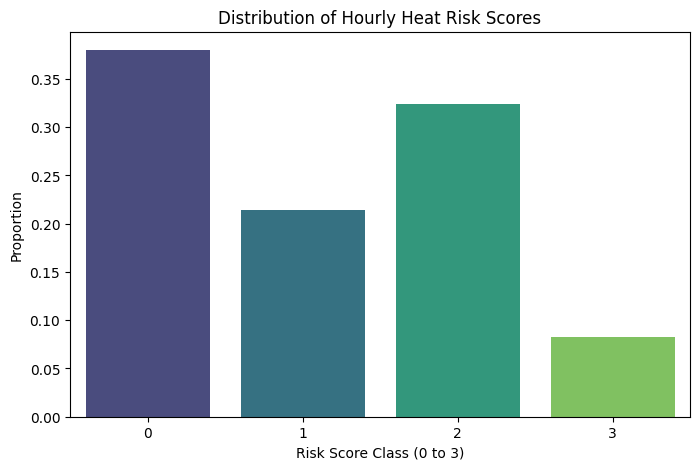

In [6]:
# Visualization of the Target Variable
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 5))
sns.barplot(x=risk_dist.index, y=risk_dist.values, palette="viridis")
plt.title("Distribution of Hourly Heat Risk Scores")
plt.xlabel("Risk Score Class (0 to 3)")
plt.ylabel("Proportion")
plt.show()

Imbalanced classed noted.This is expected as heatwaves are less common that normal weather days

Merging Population and Creating Vulnerability Index

In [16]:
# Merging Population Data (Vulnerability Layer) 

print(f"👥 Loading district metadata from: {INPUT_META_FILE}...")
meta = pd.read_csv(INPUT_META_FILE)

# 1. Standardize Metadata Names
meta['district_name'] = meta['district_name'].str.strip().str.title()

# 2. PATCH: Fix Mismatches in the Climate Data BEFORE merging
# Force Title Case on Weather Data to match Metadata
df['district_name'] = df['district_name'].str.strip().str.title()

# Apply specific patches
patch_corrections = {
    "Gujarat": "Gujrat",             
    "Karachi West": "Karachi West",  
    "Rann Of Kutch": "Rann Of Kutch" 
}
df['district_name'] = df['district_name'].replace(patch_corrections)

# --- CRITICAL FIX: SAFETY DROP ---
# If population_2020 already exists (from a previous run), drop it first.
cols_to_drop = ['population_2020', 'pop_log', 'pop_risk_intensity']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# 3. Merge
print("   Merging population data...")
df = df.merge(meta[['district_name', 'population_2020']], on='district_name', how='left')

# 4. Check for failures
missing_rows = df['population_2020'].isnull().sum()
if missing_rows > 0:
    print(f"    WARNING: {missing_rows} rows still have no population match.")
    print(f"   Failing Districts: {df[df['population_2020'].isnull()]['district_name'].unique()}")
else:
    print("    SUCCESS: All rows matched! Zero data loss.")

df['population_2020'] = df['population_2020'].fillna(0).astype(int)
print(f"   Max Population: {df['population_2020'].max():,}")

# --- Feature 4: Creating Population Risk Intensity ---
print("   Creating Vulnerability Features...")
df['pop_log'] = np.log10(df['population_2020'] + 1)
df['pop_risk_intensity'] = df['risk_score'] * df['pop_log']
print("Created Population Risk Intensity Feature.")

👥 Loading district metadata from: ../data/processed/district_metadata.csv...
   Merging population data...
    SUCCESS: All rows matched! Zero data loss.
   Max Population: 10,412,800
   Creating Vulnerability Features...
Created Population Risk Intensity Feature.


In [17]:
# Creating Population Risk Intensity 

print("   Creating Vulnerability Features...")

# Use log-transformed population to prevent high populations from dominating the model
# We use log10(Pop + 1) to handle zero population gracefully
df['pop_log'] = np.log10(df['population_2020'] + 1)

# Population Risk Intensity = Risk Score * Log(Population)
# This gives us a weighted metric: "How many people are exposed to this risk level?"
df['pop_risk_intensity'] = df['risk_score'] * df['pop_log']

print("Created Population Risk Intensity Feature.")

   Creating Vulnerability Features...
Created Population Risk Intensity Feature.


Lagged Features (Time-Series Memory)

In [18]:
# Lagged Features (Duration and Build-up)

print("--- Creating Lagged Features (Heatwave Memory) ---")

# 1. Sort data to ensure correct lagging calculation (Crucial!)
df = df.sort_values(['district_name', 'time']).reset_index(drop=True)

# 2. Rolling Mean Temperature (Last 24 hours)
# Captures "Thermal Inertia" - buildings stay hot even if air cools
df['temp_roll_24h'] = df.groupby('district_name')['temp_c'].transform(
    lambda x: x.shift(1).rolling(window=24, min_periods=1).mean()
)

# 3. Maximum Heat Index (Last 3 Days / 72h)
# Captures "Heatwave Accumulation" - prolonged heat is deadlier
df['hi_max_72h'] = df.groupby('district_name')['heat_index_c'].transform(
    lambda x: x.shift(1).rolling(window=72, min_periods=1).max()
)

# 4. Previous Hour's Risk Score
# Captures "Persistence" - if it was dangerous an hour ago, it's likely dangerous now
df['risk_lag_1h'] = df.groupby('district_name')['risk_score'].shift(1)

# --- SAFE FILLNA STRATEGY ---
# 1. Fill the Risk Lag with 0 (Safe) for the first hour
df['risk_lag_1h'] = df['risk_lag_1h'].fillna(0)

# 2. Fill the Rolling Temps with the actual current temp (Backfill)
# If the rolling avg is NaN (start of data), assume it equals the current temp
df['temp_roll_24h'] = df['temp_roll_24h'].fillna(df['temp_c'])
df['hi_max_72h'] = df['hi_max_72h'].fillna(df['heat_index_c'])

print(" Created rolling and lagged features.")
print(df[['time', 'district_name', 'temp_c', 'temp_roll_24h', 'risk_score', 'risk_lag_1h']].head())

--- Creating Lagged Features (Heatwave Memory) ---
 Created rolling and lagged features.
                 time district_name    temp_c  temp_roll_24h  risk_score  \
0 2015-04-01 00:00:00    Abbottabad   9.15640       9.156400           0   
1 2015-04-01 01:00:00    Abbottabad   9.36138       9.156400           0   
2 2015-04-01 02:00:00    Abbottabad   9.68310       9.258890           0   
3 2015-04-01 03:00:00    Abbottabad  10.53277       9.400293           0   
4 2015-04-01 04:00:00    Abbottabad  11.05197       9.683413           0   

   risk_lag_1h  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  


Small Test to Check Engineered Features

In [20]:
print("STARTING DIAGNOSTICS...\n")
errors = []

# 1. CHECK MISSING VALUES
# Critical columns cannot have NaNs, or the model will crash
critical_cols = ['heat_index_c', 'risk_score', 'population_2020', 'pop_risk_intensity', 'temp_roll_24h']
nulls = df[critical_cols].isnull().sum()
if nulls.sum() > 0:
    errors.append(f"CRITICAL FAIL: Found missing values in {list(nulls[nulls > 0].index)}")
else:
    print(" PASS: No missing values in critical columns.")

# 2. CHECK PHYSICS (Humidity & Heat Index)
# RH must be 0-100. Heat Index usually shouldn't be below Temp (unless very dry).
if df['humidity_relative'].min() < 0 or df['humidity_relative'].max() > 100:
    errors.append(" FAIL: Relative Humidity out of bounds (0-100).")
else:
    print("PASS: Relative Humidity is valid (0-100%).")

# 3. CHECK TARGET VARIABLE LOGIC
# If Heat Index > 42, Risk Score MUST be 3 (Extreme Danger).
# Let's test a sample.
high_risk_sample = df[df['heat_index_c'] > 42]
if not high_risk_sample.empty:
    if (high_risk_sample['risk_score'] == 3).all():
        print(" PASS: Risk Score logic holds (HI > 42 is Class 3).")
    else:
        errors.append("FAIL: Found rows with HI > 42 but Risk Score != 3.")
else:
    print(" WARN: No extreme heat (>42C) found in dataset to test.")

# 4. CHECK TIME-SERIES LAG LOGIC
# Check if 'risk_lag_1h' actually equals the previous hour's 'risk_score'
# We pick one district to test
test_dist = df['district_name'].unique()[0]
d_df = df[df['district_name'] == test_dist].sort_values('time').iloc[10:15] # Grab 5 rows
# The lag of Row N should equal the score of Row N-1
if d_df.iloc[1]['risk_lag_1h'] == d_df.iloc[0]['risk_score']:
    print(f" PASS: Lag features are working correctly for {test_dist}.")
else:
    errors.append(f" FAIL: Lag feature mismatch in {test_dist}.")

# 5. CHECK POPULATION MERGE
# Ensure big cities didn't get zeroed out
lahore_pop = df[df['district_name'] == 'Lahore']['population_2020'].max()
if lahore_pop > 5_000_000:
    print(f" PASS: Population Merge looks good (Lahore: {lahore_pop:,.0f}).")
else:
    errors.append(f" FAIL: Lahore population is suspiciously low ({lahore_pop}). Check Merge.")

print("\n" + "="*30)
if not errors:
    print("ALL SYSTEMS GO. READY FOR FINAL SAVE.")
else:
    print("\n".join(errors))
    print(" Do not proceed to modeling until fixed.")

STARTING DIAGNOSTICS...

 PASS: No missing values in critical columns.
PASS: Relative Humidity is valid (0-100%).
 PASS: Risk Score logic holds (HI > 42 is Class 3).
 PASS: Lag features are working correctly for Abbottabad.
 PASS: Population Merge looks good (Lahore: 10,412,800).

ALL SYSTEMS GO. READY FOR FINAL SAVE.


Total Wind Speed

In [23]:
# Formula: sqrt(u^2 + v^2)
df['wind_speed_m_s'] = np.sqrt(df['wind_u']**2 + df['wind_v']**2)
print("Calculated Wind Speed Magnitude.")

Calculated Wind Speed Magnitude.


Final Cleanup and Save

In [24]:
# Select final features (dropping intermediate conversions like temp_c, dew_point_c, etc.)
# and dropping rows where lagging resulted in NA (should be few)
FINAL_COLUMNS = [
    'time', 'district_name', 
    'population_2020', 'pop_log', # Static Vulnerability Features
    
    # Current Weather Features
    'temp_c', 'humidity_relative', 'wind_speed_m_s', 'solar_w_m2', 
    
    # Lagged/Memory Features
    'temp_roll_24h', 'hi_max_72h', 'risk_lag_1h',
    
    # Target Variables
    'heat_index_c', 'risk_score', 'pop_risk_intensity'
]

df_final = df[FINAL_COLUMNS].dropna()

OUTPUT_FILE = os.path.join(OUTPUT_DIR_FINAL, "final_training_data.csv")
print(f"Saving final training set ({len(df_final):,} rows) to {OUTPUT_FILE}")
df_final.to_csv(OUTPUT_FILE, index=False)

print("\n Feature Engineering (Notebook 03) Complete! We are ready for Modeling.")

Saving final training set (5,616,000 rows) to ../data/processed/final_training_data.csv

 Feature Engineering (Notebook 03) Complete! We are ready for Modeling.
